In [1]:
""" Quick analizer for the station 0-20000-0-10962 
      focus on the date '2014-12-10T06:00:00.000000000', '2014-12-10T06:00:28.000000000' 
      i.e. two distinct records only 28 seconds apart.
      This originates from the merging of NCAR and ERA5 data """

import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt

%matplotlib inline
%pylab inline

#matplotlib.use('Agg')

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)



""" Files list """
merged = '/raid60/scratch/federico/JULY_MERGE/0-20000-0-10962_CEUAS_merged_v0.nc' 
era5      = '/raid60/scratch/federico/HARVESTED_JULY2020/era5_1/0-20000-0-10962_era5_1_harvested_era5.conv.??????.10962.txt.gz.nc'
ncar      = '/raid60/scratch/federico/HARVESTED_JULY2020/ncar/0-20000-0-10962_ncar_harvested_uadb_trhc_10962.txt.nc'
igra       = '/raid60/scratch/federico/HARVESTED_JULY2020/igra2/0-20000-0-10962_igra2_harvested_GMM00010962-data.txt.nc'


""" Loading the observations table """
################## observations_table indices = ot_era5[3935484:3935694] 
ot_era5 = xr.open_dataset (era5, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_era5 = ot_era5 [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_era5 = xr.open_dataset(era5, engine = 'h5netcdf' , decode_times = True )['recordtimestamp'] # found in [3831:3832] 
ri_era5 = xr.open_dataset(era5, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_ncar[2465:2466] , ot_ncar[812950:812960] 
ot_ncar = xr.open_dataset (ncar, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_ncar = ot_ncar [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_ncar = xr.open_dataset(ncar, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_ncar = xr.open_dataset(ncar, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_igra[3084:3094] ,  ot_igra[1034550:1034570]  
ot_igra = xr.open_dataset (igra, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_igra = ot_igra [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_igra = xr.open_dataset(igra, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_igra = xr.open_dataset(igra, engine = 'h5netcdf' , decode_times = True )['recordindex']

################## dt_merged[5578:5590] ot_merged[3302156:3302256] 
ot_merged = xr.open_dataset (merged, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot_merged = ot_merged [ [ "date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
dt_merged = xr.open_dataset(merged, engine = 'h5netcdf' , decode_times = True )['recordtimestamp']
ri_merged = xr.open_dataset(merged, engine = 'h5netcdf' , decode_times = True )['recordindex']

ht_merged = xr.open_dataset (merged, engine = 'h5netcdf'  , group = "header_table", decode_times = True ).to_dataframe()
ht_merged = ht_merged[['record_timestamp' , 'report_timestamp' , 'report_id', 'duplicates']]


date_time   = ot_merged[3302156:3302256]['date_time'][0]  # 2014-12-10 06:00:00
date_time_2 = ot_merged[3303156:3303256]['date_time'][0]  # 2014-12-10 06:00:00

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [6]:
def plot_profile(var = 85):
    
    def get_df(var='', ot = '', date_time = '' ):
        red = ot.loc [  (ot['date_time'] == date_time) &   (ot['observed_variable'] == var)  &   (ot['z_coordinate_type'] == 1) ]
        print('max p is' , max(red['z_coordinate']) )
        return list(red['observation_value'])[::-1], list(red['z_coordinate']/100)[::-1]
    
    
    def plot(igra_t, igra_p, ncar_t, ncar_p, era5_t, era5_p ):
        fs = 18
        os.system('mkdir output')
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
        fig.suptitle('Profile for the record 2014-12-10 06:00:00, Station 10962 (HOHENPEISSENBERG, Germany)' , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        w = ax1.invert_yaxis() 
        ax1.set_ylabel( 'Pressure [hPa]'   , fontsize = fs )     
        ax1.set_xlabel( 'Temperature [K]' , fontsize = fs )        
        ax1.grid(ls =":" , color = "lightgray")
        #plt.xlim(date_min, date_max)
        #ax.set_xticks(x)
        #ax.set_xticklabels(labels, fontsize = fs )
        
        #plt.scatter(igra_t, igra_p , label = 'IGRA2'     , color = 'blue')
        #plt.scatter(ncar_t, ncar_p , label = 'NCAR'    , color = 'limegreen')
        #plt.scatter(era5_t, era5_p , label = 'ERA5 1' , color = 'orange')
        
        ax1.plot(igra_t, igra_p , label = 'IGRA2'     , color = 'blue')
        #rint(igra_t)
        #print('***')
        #print(igra_p)
        ax1.plot(ncar_t, ncar_p , label = 'NCAR'    , color = 'limegreen')
        
        #rint(ncar_t)
        #print('***')
        #print(ncar_p)
        
        ax1.plot(era5_t, era5_p , label = 'ERA5 1' , color = 'orange')
        
        #print(era5_t)
        #print('***')
        #print(era5_p)
        
        ax1.legend(loc = 'lower left', fontsize = fs-2)            

        ax2.tick_params(axis='both', which='major', labelsize=15)
        ax2.tick_params(axis='both', which='minor', labelsize=8)
        w = ax2.invert_yaxis()      
        
        temp, press = get_diff(igra_t, ncar_t, igra_p, ncar_p)
        print(temp, '\n', press)
        ax2.plot(temp, press, label = 'IGRA2-NCAR'     , color = 'green')
        
        temp, press = get_diff(igra_t, era5_t, igra_p, era5_p)
        ax2.plot(temp, press, label = 'IGRA2-ERA5 1'     , color = 'magenta')
        ax2.grid(ls =":" , color = "lightgray")
        ax2.set_xlabel( 'Temperature Diff. [K]' , fontsize = fs )        
        ax2.legend(loc = 'lower left', fontsize = fs - 2)            


        #plt.close()
        plt.savefig("output/" + '/' + 'profiles.png' ,   bbox_inches = 'tight' , dpi = 250 )



    def get_diff(t_1, t_2, p_1, p_2): # igra_t, era5_t, igra_p, era5_p
        """ Extract the difference of the two vectors """
        diff_t, diff_p = [], []
        for t1,p1 in zip(t_1, p_1 ):
            if p1 in p_2:
                index = p_2.index(p1)
                if np.isnan(t1): continue

                t2 = t_2[index]
                if np.isnan(t2): continue

                diff_t.append(t1-t2)
                diff_p.append(p1)  # append the difference 
        return diff_t, diff_p 
    
   
    igra_t, igra_p   = get_df ( var=var , ot = ot_igra , date_time=date_time )
    ncar_t, ncar_p   = get_df ( var=var , ot = ot_ncar , date_time=date_time )
    era5_t, era5_p   = get_df ( var=var , ot = ot_era5 , date_time=date_time_2 )
    
    
    a= plot(igra_t, igra_p, ncar_t, ncar_p, era5_t, era5_p)
    print('check') 
    

max p is 91100.0
max p is 100000.0
max p is 100000.0
[0.100006103515625, 0.100006103515625, 0.100006103515625, 0.0, 0.0, 0.100006103515625, 0.0, 0.100006103515625, 0.100006103515625, 0.0, 0.100006103515625, 0.0, 0.100006103515625, 0.0, 0.100006103515625, 0.100006103515625, 0.0, 0.0, 0.0, 0.0, 0.100006103515625, 0.100006103515625, 0.0, 0.0, 0.100006103515625, 0.100006103515625, 0.100006103515625, 0.0, 0.100006103515625, 0.0, 0.0, 0.0, 0.100006103515625, 0.100006103515625, 0.100006103515625, 0.0, 0.0, 0.0, 0.0, 0.100006103515625, 0.100006103515625, 0.100006103515625, 0.0, 0.0, 0.100006103515625, 0.0, 0.0, 0.0, 0.0, 0.100006103515625, 0.0, 0.0, 0.0] 
 [911.0, 895.0, 860.0, 850.0, 824.0, 817.0, 786.0, 732.0, 700.0, 680.0, 576.0, 562.0, 526.0, 500.0, 431.0, 426.0, 400.0, 370.0, 360.0, 355.0, 300.0, 293.0, 255.0, 250.0, 243.0, 200.0, 179.0, 156.0, 150.0, 131.0, 128.0, 102.0, 100.0, 91.0999984741211, 70.0, 65.19999694824219, 50.0, 46.20000076293945, 31.799999237060547, 30.0, 26.0, 22.20000076

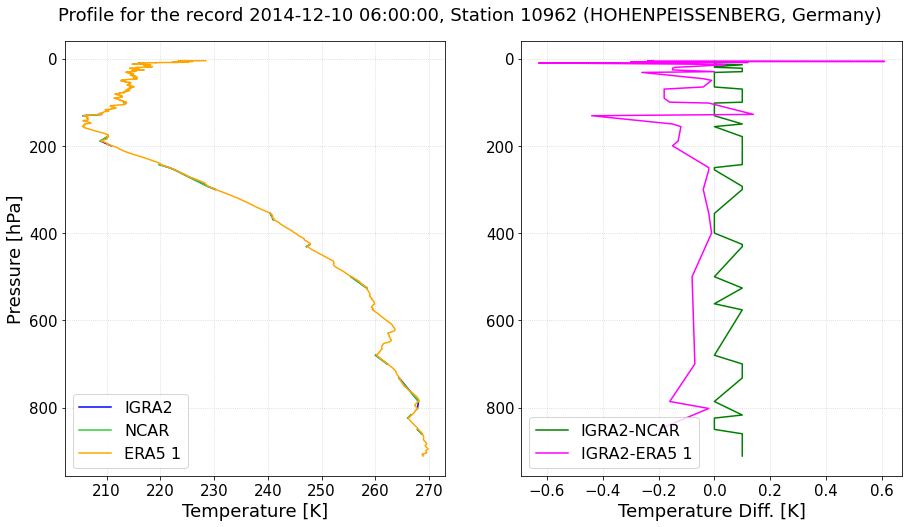

In [7]:
a = plot_profile(var = 85)
    
print('check')